<center> <h1> Clustering </h1> </center>

In [1]:
import torch
import matplotlib.pyplot as plt
import os
import numpy as np
from image_utils import load_images_from_path
from VAE_architecture import BetaVAE
from umap import UMAP
from sklearn.mixture import GaussianMixture


c:\Users\souhm\anaconda3\envs\allwhatyouneed\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = BetaVAE(beta=1, latent_dim=8)
model.load_state_dict(torch.load('./models/model_zdim_8_beta_1_epochs_50.pth'))
model.eval()

BetaVAE(
  (encoder): Encoder(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): Linear(in_features=19950, out_features=128, bias=True)
    (fc1): Linear(in_features=128, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (dense_mean): Linear(in_features=32, out_features=8, bias=True)
    (dense_log_var): Linear(in_features=32, out_features=8, bias=True)
    (sampling): Sampling()
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (dense): Linear(in_features=8, out_features=32, bias=True)
    (fc1): Linear(in_features=32, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=19950, bias=True)
  )
)

In [3]:
data_path = '../../segmentation/data_for_VAE/220429_ MCF10A  laminAC fibro phallo pattern mars 2022\*.png'
validation_split = 0.2

_,crops = load_images_from_path(data_path)
crops = np.expand_dims(crops, axis=1).astype("float32") / 255
crops = torch.tensor(crops)

split_idx = int((1 - validation_split) * len(crops))
# Shuffle the data before splitting it
size_dim_0 = crops.size(0)
shuffled_indices_dim_0 = torch.randperm(size_dim_0)
crops = crops[shuffled_indices_dim_0, ...]
train_data = crops[:split_idx]
val_data = crops[split_idx:]
print("the training data has ",train_data.size(dim=0), " patches")
print("the validation data has ",val_data.size(dim=0), " patches")

the training data has  5849  patches
the validation data has  1463  patches


In [9]:
z_mean, z_log_var, z = model.encoder(val_data)
n_clusters = 3
z = z.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z)
clustering_labels = clustering.predict(z)
umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(z)


In [5]:
# # 2D representation latent space n=2 (matplotlib)
# import numpy as np
# import matplotlib.pyplot as plt

# # Fixing random state for reproducibility

# x = z[:,0]
# y = z[:,1]

# params = {'backend': 'Agg',
#           "font.family": "calibri",
#               } # extend as needed
# plt.rcParams["axes.edgecolor"] = "0.15"
# plt.rcParams["axes.linewidth"]  = 1.25
# fig = plt.figure()

# plt.rcParams["axes.edgecolor"] = "0.15"
# plt.rcParams["axes.linewidth"]  = 1.25

# #fig, ax = plt.subplots()
# fig, ax=plt.subplots(layout="constrained")

# scatter =ax.scatter(x, y, s=3, c=labels, alpha=0.5, cmap='viridis')
# legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="lower left", title="Classes", fontsize = 5)

# ax.set_facecolor("white")
# ax.add_artist(legend1)

# #image_format = 'svg' # e.g .png, .svg, etc.
# plt.title('Prediction ( latent space=8)',fontsize = 20)
# plt.xlabel('Dim_1', fontsize = 24)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.ylabel('Dim_2',fontsize = 24)
# #fig.savefig(image_name, format=image_format, dpi=1200)

# plt.show()

In [10]:
cmap = plt.cm.get_cmap('viridis', 3)
cmap2 = cmap.reversed()

<Figure size 432x288 with 0 Axes>

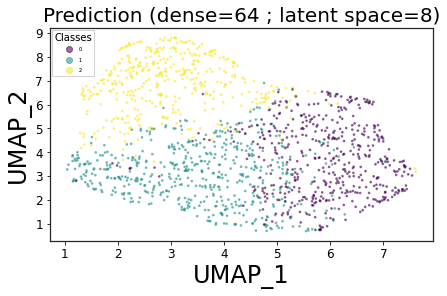

In [16]:
# 2D representation latent space n>2 matplotlib

umap_2d = UMAP(n_components=2, init='random', random_state=0) 
#tsne = Isomap(n_components=2)
#tsne = SpectralEmbedding(n_components=2)
#tsne = LocallyLinearEmbedding(n_components=2)
proj_2d = umap_2d.fit_transform(z)  
params = {'backend': 'Agg',
          "font.family": "calibri",
              } # extend as needed
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
fig = plt.figure()

plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25

fig, ax=plt.subplots(layout="constrained")

scatter =ax.scatter(x=proj_2d[:,0], y=proj_2d[:,1], s=3, c=clustering_labels, alpha=0.5, cmap=cmap)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes",fontsize = 5)

ax.set_facecolor("white")
ax.add_artist(legend1)

#image_format = 'svg' # e.g .png, .svg, etc.
#image_name = 'C:/Users/betti/Desktop/Resultats/Article VAE/saved_model/FASHION MNIST/beta=1, epoch =20, batch=32_v2/figures/latent space =32/myimage.svg'
plt.title('Prediction (dense=64 ; latent space=8)',fontsize = 20)
plt.xlabel('UMAP_1', fontsize = 24)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('UMAP_2',fontsize = 24)
# path=r'C:\Users\betti\Desktop\Resultats\Article VAE\figure_v2\MNIST\latent64_dense64_pred.png'
# plt.savefig(path, dpi=1200)

plt.show()
